In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import time
import ipywidgets as wg
from ipywidgets import interact
from IPython.display import display
import networkx as nx
from src.environment import Environment
from src.runner import runner
from src.helpers import confidence_interval
from sklearn import preprocessing
import random
import json
import os

In [2]:
style.use('seaborn-white')

# Introduction

In this notebook, we simulate three different scenarios: 

1. No intervention
2. Lockdown
3. Lockdown with slums

### 1 load general the parameters

In [3]:
with open('parameters/parameters.json') as json_file:
    parameters = json.load(json_file)

parameters['data_output'] = 'network'

## 2 load district data
### 2.1 general neighbourhood data

In [4]:
with open('parameters/district_data.json') as json_file:
    neighbourhood_data = json.load(json_file)

### 2.2 age data

In [5]:
age_distribution = pd.read_csv('input_data/age_dist.csv', sep=';', index_col=0)
age_distribution_per_ward = dict(age_distribution.transpose())

### 2.3 household size distribution

In [6]:
HH_size_distribution = pd.read_excel('input_data/HH_Size_Distribution.xlsx', index_col=0)

## 3 load travel matrix 

In [7]:
travel_matrix = pd.read_csv('input_data/Travel_Probability_Matrix.csv', index_col=0)

## 4 load contact matrices
### 4.1 load household contact matrix

In [8]:
age_groups = ['age_0_10', 'age_10_20', 'age_20_30', 'age_30_40', 'age_40_50',
              'age_50_60', 'age_60_70', 'age_70_80', 'age_80_plus']

hh_contact_matrix = pd.read_excel('input_data/ContactMatrices_10year.xlsx', sheet_name="Home", index_col=0)
hh_contact_matrix['80plus'] = hh_contact_matrix['70_80']
row = hh_contact_matrix.xs('70_80')
row.name = '80plus'
hh_contact_matrix = hh_contact_matrix.append(row)
hh_contact_matrix.columns = age_groups
hh_contact_matrix.index = age_groups

### 4.2 load other contact matrix

In [9]:
other_contact_matrix = pd.read_excel('input_data/ContactMatrices_10year.xlsx', sheet_name="OutsideOfHome", index_col=0)
other_contact_matrix['80plus'] = other_contact_matrix['70_80']
row = other_contact_matrix.xs('70_80')
row.name = '80plus'
other_contact_matrix = other_contact_matrix.append(row)
other_contact_matrix.columns = age_groups
other_contact_matrix.index = age_groups

With all the nescessary input data loaded, the first scenario can now be explored. 

In [10]:
parameters['probability_transmission'] = 0.04
parameters['monte_carlo_runs'] = 5
parameters['foreign_infection_days'] = [x for x in range(30)]

# Scenario 1 No-intervention Baseline

In this scenario, the policy maker is completely idle and COvid-19 will run its course through the city of Cape Town without interruption. 

In [11]:
parameters["lockdown_days"] = [None for x in range(len(parameters['lockdown_days']))]

In [12]:
baseline_total = []
data_folder = 'measurement/baseline/'
baseline_summary_stats = []
for seed in range(parameters['monte_carlo_runs']):
    # make new folder for seed, if it does not exist
    if not os.path.exists('{}seed{}'.format(data_folder, seed)):
        os.makedirs('{}seed{}'.format(data_folder, seed))

    # initialization
    environment = Environment(seed, parameters, neighbourhood_data, age_distribution_per_ward,
                              hh_contact_matrix, other_contact_matrix, HH_size_distribution, travel_matrix)

    # running the simulation
    environment = runner(environment, seed, data_output=parameters["data_output"], data_folder=data_folder,
                         calculate_r_naught=False)
    
    if parameters['data_output'] == 'network':
        # saving the network data
        for idx, network in enumerate(environment.infection_states):
            for i, node in enumerate(network.nodes):
                network.nodes[i]['agent'] = network.nodes[i]['agent'].status

        susceptible_ot = []
        infected_1_ot = []
        infected_2_ot = []
        critical_ot = []
        dead_ot = []
        recovered_ot = []
        exposed_ot = []

        for t in range(parameters['time']):
            network = environment.infection_states[t]
            susceptible = 0
            infected_1 = 0
            infected_2 = 0
            critical = 0
            dead = 0
            recovered = 0
            exposed = 0
            for idx, node in enumerate(network):
                if network.nodes[idx]['agent'] == 's':
                    susceptible += 1
                elif network.nodes[idx]['agent'] == 'e':
                    exposed += 1
                elif network.nodes[idx]['agent'] == 'i1':
                    infected_1 += 1
                elif network.nodes[idx]['agent'] == 'i2':
                    infected_2 += 1
                elif network.nodes[idx]['agent'] == 'c':
                    critical += 1
                elif network.nodes[idx]['agent'] == 'd':
                    dead += 1
                elif network.nodes[idx]['agent'] == 'r':
                    recovered +=1
                else:
                    print('no status?')

            susceptible_ot.append((susceptible / float(len(network))))
            infected_1_ot.append((infected_1 / float(len(network))))
            infected_2_ot.append((infected_2 / float(len(network))))
            critical_ot.append((critical / float(len(network))))
            dead_ot.append((dead / float(len(network))))
            recovered_ot.append((recovered / float(len(network))))
            exposed_ot.append((exposed / float(len(network))))

        # save output data
        baseline_total.append(exposed_ot)
        baseline_summary_stats.append({'total dead': dead_ot[-1], 'peak critical': max(critical_ot), 'total recovered':recovered_ot[-1]})
    elif parameters["data_output"] == 'csv_light':
        pd.DataFrame(environment.infection_quantities).to_csv('{}seed{}/quantities_state_time.csv'.format(data_folder,
                                                                                                          seed))

Calculate average and confidence intervals for total dead, peak critical, and total recovered + dead. 

In [13]:
if parameters['data_output'] == 'network':
    total_dead_baseline = [baseline_summary_stats[x]['total dead'] for x in range(len(baseline_summary_stats))]
    peak_critical_baseline = [baseline_summary_stats[x]['peak critical'] for x in range(len(baseline_summary_stats))]
    total_infected_baseline = [baseline_summary_stats[x]['total dead'] + baseline_summary_stats[x]['total recovered'] for x in range(len(baseline_summary_stats))]

    # av lower upper
    simulation_summary = pd.DataFrame({
        'total dead': [np.mean(total_dead_baseline), confidence_interval(total_dead_baseline, np.mean(total_dead_baseline))[0], confidence_interval(total_dead_baseline, np.mean(total_dead_baseline))[1]],
        'peak critical': [np.mean(peak_critical_baseline), confidence_interval(peak_critical_baseline, np.mean(peak_critical_baseline))[0], confidence_interval(peak_critical_baseline, np.mean(peak_critical_baseline))[1]],
        'total infected': [np.mean(total_infected_baseline), confidence_interval(total_infected_baseline, np.mean(total_infected_baseline))[0], confidence_interval(total_infected_baseline, np.mean(total_infected_baseline))[1]]
    }).transpose()
    simulation_summary.columns = ['average', 'lower', 'upper']
    print(simulation_summary)

                 average     lower     upper
total dead      0.014889  0.012906  0.016872
peak critical   0.007243  0.006012  0.008475
total infected  0.942455  0.932158  0.952751


# Scenario 2 Lockdown

In this scenario, the policy maker implements a lockdown that has been inspired by the South African lockdown. Therefore, we set the lockdown parameters as follows.

Next, we make sure that the lockdown is active during the entirity of the simulation. And that it is equally effective in all districts. 

In [14]:
parameters['informality_dummy'] = 0.0
parameters["lockdown_days"] = [x for x in range(30, len(parameters['lockdown_days']))]

In [15]:
data_folder = 'measurement/lockdown/'
lockdown_summary_stats = []
lockdown_total = []
for seed in range(parameters['monte_carlo_runs']):
    # make new folder for seed, if it does not exist
    if not os.path.exists('{}seed{}'.format(data_folder, seed)):
        os.makedirs('{}seed{}'.format(data_folder, seed))

    # initialization
    environment = Environment(seed, parameters, neighbourhood_data, age_distribution_per_ward,
                              hh_contact_matrix, other_contact_matrix, HH_size_distribution, travel_matrix)

    # running the simulation
    environment = runner(environment, seed, data_output=parameters["data_output"], data_folder=data_folder,
                         calculate_r_naught=False)
    
    # saving the network data
    if parameters['data_output'] == 'network':
        for idx, network in enumerate(environment.infection_states):
            for i, node in enumerate(network.nodes):
                network.nodes[i]['agent'] = network.nodes[i]['agent'].status

        susceptible_ot_l = []
        infected_1_ot_l = []
        infected_2_ot_l = []
        critical_ot_l = []
        dead_ot_l = []
        recovered_ot_l = []
        exposed_ot_l = []

        for t in range(parameters['time']):
            network = environment.infection_states[t]
            susceptible = 0
            infected_1 = 0
            infected_2 = 0
            critical = 0
            dead = 0
            recovered = 0
            exposed = 0
            for idx, node in enumerate(network):
                if network.nodes[idx]['agent'] == 's':
                    susceptible += 1
                elif network.nodes[idx]['agent'] == 'e':
                    exposed += 1
                elif network.nodes[idx]['agent'] == 'i1':
                    infected_1 += 1
                elif network.nodes[idx]['agent'] == 'i2':
                    infected_2 += 1
                elif network.nodes[idx]['agent'] == 'c':
                    critical += 1
                elif network.nodes[idx]['agent'] == 'd':
                    dead += 1
                elif network.nodes[idx]['agent'] == 'r':
                    recovered +=1
                else:
                    print('no status?')

            susceptible_ot_l.append((susceptible / float(len(network))))
            infected_1_ot_l.append((infected_1 / float(len(network))))
            infected_2_ot_l.append((infected_2 / float(len(network))))
            critical_ot_l.append((critical / float(len(network))))
            dead_ot_l.append((dead / float(len(network))))
            recovered_ot_l.append((recovered / float(len(network))))
            exposed_ot_l.append((exposed / float(len(network))))

        # save output data
        lockdown_total.append(exposed_ot_l)
        lockdown_summary_stats.append({'total dead': dead_ot_l[-1], 'peak critical': max(critical_ot_l), 'total recovered':recovered_ot_l[-1]})
    elif parameters["data_output"] == 'csv_light':
        pd.DataFrame(environment.infection_quantities).to_csv('{}seed{}/quantities_state_time.csv'.format(data_folder,
                                                                                                          seed))

Calculate average and confidence intervals for total dead, peak critical, and total recovered + dead.

In [16]:
if parameters['data_output'] == 'network':
    total_dead_lockdown = [lockdown_summary_stats[x]['total dead'] for x in range(len(lockdown_summary_stats))]
    peak_critical_lockdown = [lockdown_summary_stats[x]['peak critical'] for x in range(len(lockdown_summary_stats))]
    total_infected_lockdown = [lockdown_summary_stats[x]['total dead'] + lockdown_summary_stats[x]['total recovered'] for x in range(len(lockdown_summary_stats))]

    # av lower upper
    simulation_summary_l = pd.DataFrame({
        'total dead': [np.mean(total_dead_lockdown), confidence_interval(total_dead_lockdown, np.mean(total_dead_lockdown))[0], confidence_interval(total_dead_lockdown, np.mean(total_dead_lockdown))[1]],
        'peak critical': [np.mean(peak_critical_lockdown), confidence_interval(peak_critical_lockdown, np.mean(peak_critical_lockdown))[0], confidence_interval(peak_critical_lockdown, np.mean(peak_critical_lockdown))[1]],
        'total infected': [np.mean(total_infected_lockdown), confidence_interval(total_infected_lockdown, np.mean(total_infected_lockdown))[0], confidence_interval(total_infected_lockdown, np.mean(total_infected_lockdown))[1]]
    }).transpose()
    simulation_summary_l.columns = ['average', 'lower', 'upper']
    print(simulation_summary_l)

                 average     lower     upper
total dead      0.006237  0.005155  0.007320
peak critical   0.005231  0.004860  0.005603
total infected  0.382294  0.341750  0.422838


# Scenario 3 Lockdown with Townships

In this scenario, the policy maker implements a lockdown that has been inspired by the South African lockdown. Once again, we set the lockdown parameters as follows.

**The twist is that the lockdown is really not as effective in Townships** 

In [17]:
parameters['informality_dummy'] = 1.0

Next, we make sure that the lockdown is active during the entirity of the simulation. 

In [18]:
parameters["lockdown_days"] = [x for x in range(30, len(parameters['lockdown_days']))]

In [19]:
data_folder = 'measurement/inef_lockdown/'
ilockdown_total = []
i_lockdown_summary_stats = []
for seed in range(parameters['monte_carlo_runs']):
    # make new folder for seed, if it does not exist
    if not os.path.exists('{}seed{}'.format(data_folder, seed)):
        os.makedirs('{}seed{}'.format(data_folder, seed))

    # initialization
    environment = Environment(seed, parameters, neighbourhood_data, age_distribution_per_ward,
                              hh_contact_matrix, other_contact_matrix, HH_size_distribution, travel_matrix)

    # running the simulation
    environment = runner(environment, seed, data_output=parameters["data_output"], data_folder=data_folder,
                         calculate_r_naught=False)
    
    # saving the network data
    if parameters['data_output'] == 'network':
        for idx, network in enumerate(environment.infection_states):
            for i, node in enumerate(network.nodes):
                network.nodes[i]['agent'] = network.nodes[i]['agent'].status

        susceptible_ot_il = []
        infected_1_ot_il = []
        infected_2_ot_il = []
        critical_ot_il = []
        dead_ot_il = []
        recovered_ot_il = []
        exposed_ot_il = []

        for t in range(parameters['time']):
            network = environment.infection_states[t]
            susceptible = 0
            infected_1 = 0
            infected_2 = 0
            critical = 0
            dead = 0
            recovered = 0
            exposed = 0
            for idx, node in enumerate(network):
                if network.nodes[idx]['agent'] == 's':
                    susceptible += 1
                elif network.nodes[idx]['agent'] == 'e':
                    exposed += 1
                elif network.nodes[idx]['agent'] == 'i1':
                    infected_1 += 1
                elif network.nodes[idx]['agent'] == 'i2':
                    infected_2 += 1
                elif network.nodes[idx]['agent'] == 'c':
                    critical += 1
                elif network.nodes[idx]['agent'] == 'd':
                    dead += 1
                elif network.nodes[idx]['agent'] == 'r':
                    recovered +=1
                else:
                    print('no status?')

            susceptible_ot_il.append((susceptible / float(len(network))))
            infected_1_ot_il.append((infected_1 / float(len(network))))
            infected_2_ot_il.append((infected_2 / float(len(network))))
            critical_ot_il.append((critical / float(len(network))))
            dead_ot_il.append((dead / float(len(network))))
            recovered_ot_il.append((recovered / float(len(network))))
            exposed_ot_il.append((exposed / float(len(network))))

        # save output data
        ilockdown_total.append(exposed_ot_il)
        i_lockdown_summary_stats.append({'total dead': dead_ot_il[-1], 'peak critical': max(critical_ot_il), 'total recovered':recovered_ot_il[-1]})
    elif parameters["data_output"] == 'csv_light':
        pd.DataFrame(environment.infection_quantities).to_csv('{}seed{}/quantities_state_time.csv'.format(data_folder,
                                                                                                          seed))

Calculate average and confidence intervals for total dead, peak critical, and total recovered + dead.

In [20]:
if parameters['data_output'] == 'network':
    total_dead_i_lockdown = [i_lockdown_summary_stats[x]['total dead'] for x in range(len(i_lockdown_summary_stats))]
    peak_critical_i_lockdown = [i_lockdown_summary_stats[x]['peak critical'] for x in range(len(i_lockdown_summary_stats))]
    total_infected_i_lockdown = [i_lockdown_summary_stats[x]['total dead'] + i_lockdown_summary_stats[x]['total recovered'] for x in range(len(i_lockdown_summary_stats))]

    # av lower upper
    simulation_summary_il = pd.DataFrame({
        'total dead': [np.mean(total_dead_i_lockdown), confidence_interval(total_dead_i_lockdown, np.mean(total_dead_i_lockdown))[0], confidence_interval(total_dead_i_lockdown, np.mean(total_dead_i_lockdown))[1]],
        'peak critical': [np.mean(peak_critical_i_lockdown), confidence_interval(peak_critical_i_lockdown, np.mean(peak_critical_i_lockdown))[0], confidence_interval(peak_critical_i_lockdown, np.mean(peak_critical_i_lockdown))[1]],
        'total infected': [np.mean(total_infected_i_lockdown), confidence_interval(total_infected_i_lockdown, np.mean(total_infected_i_lockdown))[0], confidence_interval(total_infected_i_lockdown, np.mean(total_infected_i_lockdown))[1]]
    }).transpose()
    simulation_summary_il.columns = ['average', 'lower', 'upper']
    print(simulation_summary_il)

                 average     lower     upper
total dead      0.008048  0.006191  0.009905
peak critical   0.004427  0.003684  0.005169
total infected  0.472032  0.420856  0.523208


In [21]:
baseline_total_df = pd.DataFrame(baseline_total).transpose()
lockdown_total_df = pd.DataFrame(lockdown_total).transpose()
ilockdown_total_df = pd.DataFrame(ilockdown_total).transpose()

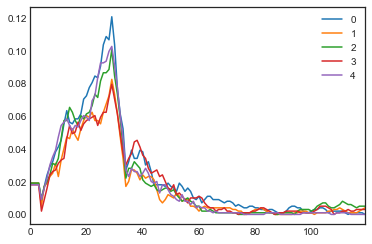

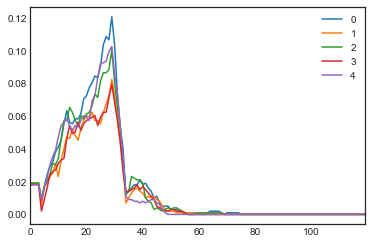

In [28]:
ilockdown_total_df.plot()
lockdown_total_df.plot()

In [23]:
lower_baseline_exposed = []
upper_baseline_exposed = []
for row in range(len(baseline_total_df)):
    exposed_range = baseline_total_df.iloc[row]
    lower, upper = confidence_interval(exposed_range, np.mean(exposed_range))
    lower_baseline_exposed.append(max(lower, 0.0))
    upper_baseline_exposed.append(upper)

lower_lockdown_exposed = []
upper_lockdown_exposed = []
for row in range(len(lockdown_total_df)):
    exposed_range = lockdown_total_df.iloc[row]
    lower, upper = confidence_interval(exposed_range, np.mean(exposed_range))
    lower_lockdown_exposed.append(max(lower, 0.0))
    upper_lockdown_exposed.append(upper)

lower_if_exposed = []
upper_if_exposed = []
for row in range(len(ilockdown_total_df)):
    exposed_range = ilockdown_total_df.iloc[row]
    lower, upper = confidence_interval(exposed_range, np.mean(exposed_range))
    lower_if_exposed.append(max(lower, 0.0))
    upper_if_exposed.append(upper)

c:\users\joeri\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\_distn_infrastructure.py:1920: RuntimeWarning: invalid value encountered in multiply
  lower_bound = self.a * scale + loc
c:\users\joeri\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\_distn_infrastructure.py:1921: RuntimeWarning: invalid value encountered in multiply
  upper_bound = self.b * scale + loc


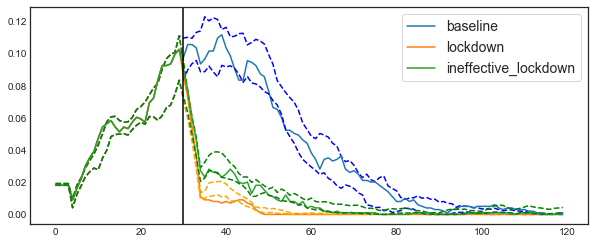

In [27]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,4))

ax1.plot(range(len(exposed_ot_il)), upper_baseline_exposed, color='blue', ls='--')
ax1.plot(range(len(exposed_ot)), exposed_ot, label='baseline')
ax1.plot(range(len(exposed_ot_il)), lower_baseline_exposed, color='blue', ls='--')

ax1.plot(range(len(exposed_ot_il)), upper_lockdown_exposed, color='orange', ls='--')
ax1.plot(range(len(exposed_ot_il)), exposed_ot_l, label='lockdown')
ax1.plot(range(len(exposed_ot_il)), lower_lockdown_exposed, color='orange', ls='--')

ax1.plot(range(len(exposed_ot_il)), upper_if_exposed, color='green', ls='--')
ax1.plot(range(len(exposed_ot_il)), exposed_ot_il, label='ineffective_lockdown')
ax1.plot(range(len(exposed_ot_il)), lower_if_exposed, color='green', ls='--')

ax1.axvline(parameters["lockdown_days"][0], color='black')


ax1.legend(loc='best', fontsize='14', frameon=True)